# 三维卷积神经网络预测MNIST数字详解
在这一节中，你将学习如何创建一个简单的三层卷积网络来预测 MNIST 数字。这个深层网络由两个带有 ReLU 和 maxpool 的卷积层以及两个全连接层组成。

MNIST 由 60000 个手写体数字的图片组成。本节的目标是高精度地识别这些数字。

# 具体实现过程

1. 导入 tensorflow、matplotlib、random 和 numpy。然后，导入 mnist 数据集并进行独热编码。请注意，TensorFlow 有一些内置的库来处理 MNIST，我们也会用到它们：

In [1]:
from __future__ import division,print_function
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

D:\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [2]:
# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Database/MNIST_data/', one_hot=True) # 如指定的文件夹里没有数据集，则会自动下载

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../Database/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../Database/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../Database/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Database/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


2. 仔细观察一些数据有助于理解 MNIST 数据集。了解训练数据集中有多少张图片，测试数据集中有多少张图片。可视化一些数字，以便了解它们是如何表示的。这种输出可以对于识别手写体数字的难度有一种视觉感知，即使是对于人类来说也是如此。

In [3]:
a1 = np.array([[3, 6, 4, 12, 5]])
a2 = np.array([[3, 6, 4, 12, 5]])
a3 = np.concatenate((a1, a2),axis=1) # 默认 axis=0 表示按行方向拼接，axis=1 表示按列方向拼接
print(a3)

[[ 3  6  4 12  5  3  6  4 12  5]]


Total Training Examples in Dataset =(55000, 784)
--------------------------------------------------
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


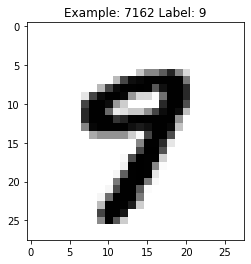

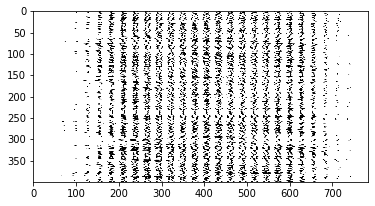

In [4]:
def train_size(num):
    print('Total Training Examples in Dataset =' +
          str(mnist.train.images.shape))
    print('-' * 50)

    x_train = mnist.train.images[:num, :]
    print('x_train Examples Loaded = ' + str(x_train.shape))

    y_train = mnist.train.labels[:num, :]
    print('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train


def test_size(num):
    print('Total Test Examples in Dataset =' + str(mnist.test.images.shape))
    print('-' * 50)

    x_test = mnist.test.images[:num, :]
    print('x_test Examples Loaded = ' + str(x_test.shape))

    y_test = mnist.test.labels[:num, :]
    print('y_test Examples Loaded = ' + str(y_test.shape))
    print('')
    return x_test, y_test


def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0) # 采用的是独热的编码 标签最大值的索引就是 识别的正确的标签
    image = x_train[num].reshape([28, 28])
    plt.title('Example: %d Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    """把从start 到 stop 的图像分别转成一行 然后在按行拼接在一起"""
    images = x_train[start].reshape([1,784])
    for  i in range(start+1,stop):
        images = np.concatenate((images,x_train[i].reshape([1,784]))) # 按行拼接
    plt.imshow(images,cmap=plt.get_cmap('gray_r'))
    plt.show()


x_train,y_train = train_size(55000)
display_digit(np.random.randint(0,x_train.shape[0]))
display_mult_flat(0,400)

3. 设置学习参数 batch_size和display_step。另外，MNIST 图片都是 28×28 像素，因此设置 n_input=784，n_classes=10 代表输出数字 [0-9]，并且 dropout 概率是 0.85，则：

In [5]:
# Parameters
learning_rate = 0.0001
training_iters = 10000
batch_size = 256
display_step =100
# Network Parameters
n_input = 784
# MNIST data input (img shape: 28 * 28)
n_classes = 10
# MNIST total classes (0 - 9 digits)
dropout = 0.85
# Dropout, probability to keep units

4. 设置 TensorFlow 计算图的输入。定义两个占位符来存储预测值和真实标签：

In [6]:
x = tf.placeholder(tf.float32, [None, n_input], name='X')
y = tf.placeholder(tf.float32, [None, n_classes], name='Y')
keep_prob = tf.placeholder(tf.float32, name='Keep_prob')

5. 定义一个输入为 x，权值为 W，偏置为 b，给定步幅的卷积层。激活函数是 ReLU，padding 设定为 SAME 模式(SAME 模式 填充图像)：

In [7]:
def conv2d(x, w, b, strides=1):
    """一个卷积2维操作
    x: 输入数据 输入的要做卷积的图片，要求为一个张量，shape为 [ batch, in_height, in_weight, in_channel ]
    w: filter： 卷积核，要求也是一个张量，shape为 [ filter_height, filter_weight, in_channel, out_channels ]
    b: 偏执
    strides: 卷积时移动的步长
    """
    x = tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

6. 定义一个输入是 x 的 maxpool 层，卷积核为 ksize 并且 padding 为 SAME：

In [8]:
def maxpool2d(x, k=2):
    """一个2维最大池化操作
    x: 输入数据
    k: 步长
    """
    # value 需要池化的输入，一般池化层接在卷积层后面，所以输入通常是feature map，依然是[batch, height, width, channels]这样的shape
    # ksize 池化窗口的大小，取一个四维向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1
    # strides：和卷积类似，窗口在每一个维度上滑动的步长，一般也是[1, stride,stride, 1]
    # 参数padding：和卷积类似，可以取'VALID' 或者'SAME'
    return tf.nn.max_pool(value=x,
                          ksize=[1, k, k, 1],
                          strides=[1, k, k, 1],
                          padding='SAME')

7. 定义 convnet，其构成是两个卷积层，然后是全连接层，一个 dropout 层，最后是输出层：

In [9]:
def conv_net(x, weights, biases, dropout):
    # reshape the input picture
    x = tf.reshape(x,
                   shape=[-1, 28, 28,
                          1])  # -1表示任意数量的样本数与定义占位符时的 None一个意思,大小为28x28深度为一的张量

    # First convolution layer
    conv1 = conv2d(x, weights['wc1'],
                   biases['bc1'])  # 图像大小和输入的一样 28 X 28 通道变为32
    # Max Pooling used for downsampling
    max_pool1 = maxpool2d(conv1, k=2)  # 池化窗口为 2X2 图像的大小变为输入的一半 14 X 14 通道不变

    # Second convolution layer
    conv2 = conv2d(max_pool1, weights['wc2'],
                   biases['bc2'])  # 图像大小和输入的一样 14 X 14 通道变为64
    # Max Pooling  used for downsampling
    max_pool2 = maxpool2d(conv2, k=2)  #池化窗口为 2X2 图像的大小变为输入的一半 7 X 7 通道不变为64

    # Reshape conv2 output to match the input of fully connected layer
    # 转成一维的
    # -1表示任意数量的样本数
    # weights['wd1'].get_shape().as_list()[0]=7*7*64
    fc1 = tf.reshape(max_pool2, [-1, weights['wd1'].get_shape().as_list()[0]])

    # Fully connect layer
    fc1 = tf.add(
        tf.matmul(fc1, weights['wd1']), biases['bd1']
    )  # 把fc1大小为[-1,7*7*64] 与矩阵 weights['wd1']相乘 在加上偏执 biases['bd1']
    fc1 = tf.nn.relu(fc1)

    # Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output the class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out

### CNN卷积神经网络卷积后的大小计算
stride是指卷积核在输入上移动时每次移动的距离。假设输入大小为 n×n，卷积核大小为 f×f，padding 大小为 p，stride 大小为 s,那么最后的输出大小为：$$\frac { n + 2 p - f } { s } + 1$$
8. 定义网络层的权重和偏置。第一个 conv 层有一个 5×5 的卷积核，1 个通道输入和 32 个通道输出。第二个 conv 层有一个 5×5 的卷积核，32 个通道输入和 64 个通道输出。全连接层有 7×7×64 个通道输入和 1024 个通道输出，而第二层有 1024 个输入和 10 个输出对应于最后的数字数目。所有的权重和偏置用 randon_normal 分布完成初始化：

In [10]:
weights = {
    # 5X5 conv, 1 input, and 32 output
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5X5 conv, 32 input, and 64 output
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, and 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs for class digits
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes])),
}

Instructions for updating:
Colocations handled automatically by placer.


9. 建立一个给定权重和偏置的 convnet。定义基于 cross_entropy_with_logits 的损失函数，并使用 Adam 优化器进行损失最小化。优化后，计算精度：

In [11]:
pred = conv_net(x, weights, biases, keep_prob)

# 交叉熵损失函数
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=pred, labels=y))  # labels 传入的列表和要为1，因为y为独热编码肯定是和为1
# 优化器
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 当前的 预测与标签对比结果
corrent_prediction = tf.equal(tf.arg_max(pred, 1), tf.arg_max(y, 1))

# tf.cast(x, dtype, name=None) 类型转换
# 第一个参数 x:   待转换的数据（张量）
# 第二个参数 dtype： 目标数据类型
# 第三个参数 name： 可选参数，定义操作的名称

accuracy = tf.reduce_mean(tf.cast(corrent_prediction, tf.float32)) # True 转成1.0 False转为0.0 均值就是准确度

init = tf.global_variables_initializer()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.math.argmax` instead


10. 启动计算图并迭代 training_iterats次，其中每次输入 batch_size 个数据进行优化。请注意，用从 mnist 数据集分离出的 mnist.train 数据进行训练。每进行 display_step 次迭代，会计算当前的精度。最后，在 2048 个测试图片上计算精度，此时无 dropout。

In [12]:
train_loss = []  #训练的loss
train_acc = []  #训练数据的准确度
test_acc = []  #测试数据的准确度
start_time = time()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer,
                 feed_dict={
                     x: batch_x,
                     y: batch_y,
                     keep_prob: dropout
                 })
        if step % display_step == 0:
            loss_train, acc_train = sess.run([cost, accuracy],
                                             feed_dict={
                                                 x: batch_x,
                                                 y: batch_y,
                                                 keep_prob: 1.0
                                             })

            print('Iter' + str(step) + ",Minibatch Loss=" +
                  "{:.2f}".format(loss_train) + ", Training Accuracy = " +
                  "{:.2f}".format(acc_train))

            # Calculate accuracy for 2048 mnist test images.
            # Note that in this case no droput
            acc_test = sess.run(accuracy,
                                feed_dict={
                                    x: mnist.test.images,
                                    y: mnist.test.labels,
                                    keep_prob: 1.0
                                })
            print("Testing Accuracy:{:.2f}".format(acc_test) +
                  ",Time consuming:{:.2f}".format(time() - start_time))

            train_acc.append(acc_train)
            train_loss.append(loss_train)
            test_acc.append(acc_test)
        step += 1

    print('Done ')

Iter100,Minibatch Loss=14661.49, Training Accuracy = 0.29
Testing Accuracy:0.30,Time consuming:9.00
Iter200,Minibatch Loss=7562.08, Training Accuracy = 0.59
Testing Accuracy:0.59,Time consuming:13.00
Iter300,Minibatch Loss=4743.31, Training Accuracy = 0.70
Testing Accuracy:0.72,Time consuming:17.05
Iter400,Minibatch Loss=3532.77, Training Accuracy = 0.79
Testing Accuracy:0.79,Time consuming:21.02
Iter500,Minibatch Loss=2357.65, Training Accuracy = 0.80
Testing Accuracy:0.83,Time consuming:25.07
Iter600,Minibatch Loss=1776.42, Training Accuracy = 0.86
Testing Accuracy:0.85,Time consuming:29.23
Iter700,Minibatch Loss=2110.10, Training Accuracy = 0.88
Testing Accuracy:0.87,Time consuming:33.46
Iter800,Minibatch Loss=2182.61, Training Accuracy = 0.87
Testing Accuracy:0.88,Time consuming:37.39
Iter900,Minibatch Loss=2074.93, Training Accuracy = 0.89
Testing Accuracy:0.89,Time consuming:41.53
Iter1000,Minibatch Loss=2074.31, Training Accuracy = 0.88
Testing Accuracy:0.90,Time consuming:46.36

Testing Accuracy:0.97,Time consuming:339.50
Iter8300,Minibatch Loss=113.68, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:343.49
Iter8400,Minibatch Loss=34.34, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:347.66
Iter8500,Minibatch Loss=125.61, Training Accuracy = 0.97
Testing Accuracy:0.97,Time consuming:351.65
Iter8600,Minibatch Loss=117.41, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:355.78
Iter8700,Minibatch Loss=148.39, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:359.78
Iter8800,Minibatch Loss=130.71, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:363.78
Iter8900,Minibatch Loss=41.05, Training Accuracy = 0.99
Testing Accuracy:0.97,Time consuming:367.98
Iter9000,Minibatch Loss=49.94, Training Accuracy = 0.99
Testing Accuracy:0.97,Time consuming:371.98
Iter9100,Minibatch Loss=174.18, Training Accuracy = 0.98
Testing Accuracy:0.97,Time consuming:376.16
Iter9200,Minibatch Loss=66.44, Training Accuracy =

11. 画出每次迭代的 Softmax 损失以及训练和测试的精度：

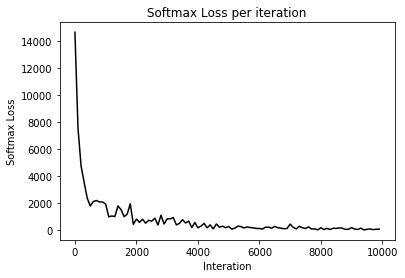

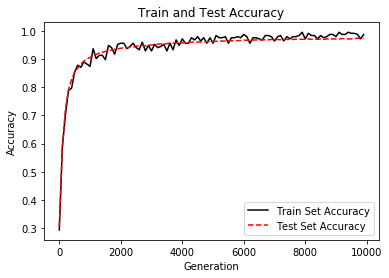

In [13]:
eval_indices = range(0, training_iters, display_step)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per iteration')
plt.xlabel('Interation')
plt.ylabel('Softmax Loss')
plt.show()
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title("Train and Test Accuracy")
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# 解读分析

使用 ConvNet，在 MNIST 数据集上的表现提高到了近 95% 的精度。ConvNet 的前两层网络由卷积、ReLU 激活函数和最大池化部分组成，然后是两层全连接层（含dropout）。训练的 batch 大小为 128，使用 Adam 优化器，学习率为 0.001，最大迭代次数为 500 次。